# Polynomial Regression, Learning Curves & Bias-Variance Trade-off

This notebook explores:
1. **Polynomial Regression** - Fitting non-linear relationships
2. **Learning Curves** - Diagnosing model performance
3. **Bias-Variance Trade-off** - Understanding underfitting vs overfitting

These concepts are fundamental to understanding how to build models that generalize well.

In [25]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# Configure matplotlib
plt.rcParams['figure.figsize'] = (14, 5)
plt.style.use('seaborn-v0_8-whitegrid')

## 1. Why Polynomial Regression?

**Linear regression** assumes a linear relationship: $y = \theta_0 + \theta_1 x_1 + \theta_2 x_2 + ...$

But what if the relationship is **non-linear**?

**Polynomial regression** extends linear regression by adding powers of features:

$$y = \theta_0 + \theta_1 x + \theta_2 x^2 + \theta_3 x^3 + ... + \theta_n x^n$$

This is still **linear regression** (linear in the parameters θ), but we've transformed the features!

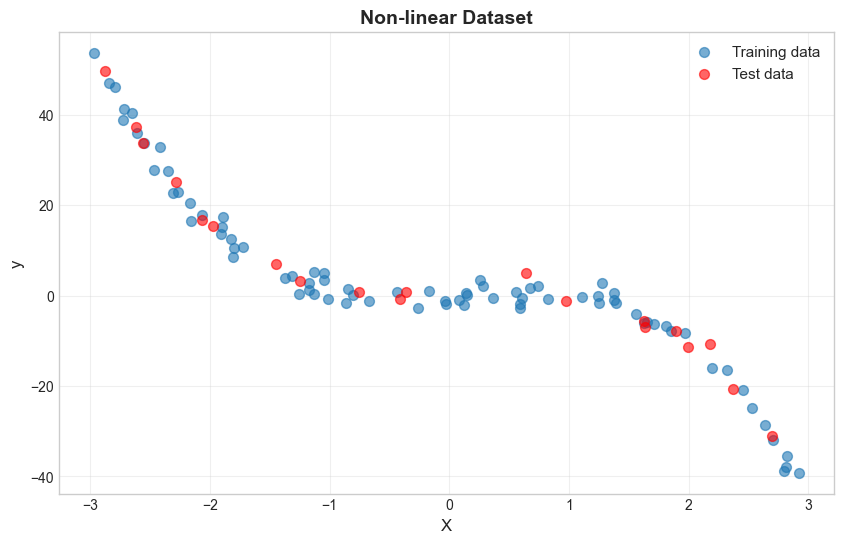

Training set size: 80 samples
Test set size: 20 samples


In [26]:
# Generate non-linear data
def generate_data(m=100, noise=0.5):
    """
    Generate data from a quadratic function with noise
    True relationship: y = 0.5 + 1.5*x - 2*x^2
    """
    X = 6 * np.random.rand(m, 1) - 3  # Random values between -3 and 3
    y = 0.5 + 1.5 * X + 0.5 * X**2 - 2 * X**3 + noise * np.random.randn(m, 1)
    return X, y

# Generate training data
X, y = generate_data(m=100, noise=2)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Visualize the data
plt.figure(figsize=(10, 6))
plt.scatter(X_train, y_train, alpha=0.6, s=50, label='Training data')
plt.scatter(X_test, y_test, alpha=0.6, s=50, color='red', label='Test data')
plt.xlabel('X', fontsize=12)
plt.ylabel('y', fontsize=12)
plt.title('Non-linear Dataset', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.show()

print(f"Training set size: {X_train.shape[0]} samples")
print(f"Test set size: {X_test.shape[0]} samples")

## 2. Polynomial Regression - Different Degrees

Let's fit polynomial models of different degrees and see how they perform.

**Key Question**: What degree polynomial should we use?

In [27]:
# Function to fit and evaluate polynomial regression
def fit_polynomial_regression(X_train, y_train, X_test, y_test, degree):
    """
    Fit a polynomial regression model of given degree
    """
    # Create polynomial features
    poly_features = PolynomialFeatures(degree=degree, include_bias=False)
    X_train_poly = poly_features.fit_transform(X_train)
    X_test_poly = poly_features.transform(X_test)
    
    # Fit linear regression on polynomial features
    model = LinearRegression()
    model.fit(X_train_poly, y_train)
    
    # Make predictions
    y_train_pred = model.predict(X_train_poly)
    y_test_pred = model.predict(X_test_poly)
    
    # Calculate errors
    train_mse = mean_squared_error(y_train, y_train_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    
    return model, poly_features, train_mse, test_mse, train_r2, test_r2

# Test different polynomial degrees
degrees = [1, 2, 3, 5, 10, 20]
results = {}

print("Polynomial Regression Results:")
print("="*85)
print(f"{'Degree':<8} {'Train MSE':<12} {'Test MSE':<12} {'Train R²':<12} {'Test R²':<12}")
print("="*85)

for degree in degrees:
    model, poly_features, train_mse, test_mse, train_r2, test_r2 = fit_polynomial_regression(
        X_train, y_train, X_test, y_test, degree
    )
    results[degree] = {
        'model': model,
        'poly_features': poly_features,
        'train_mse': train_mse,
        'test_mse': test_mse,
        'train_r2': train_r2,
        'test_r2': test_r2
    }
    print(f"{degree:<8} {train_mse:<12.4f} {test_mse:<12.4f} {train_r2:<12.4f} {test_r2:<12.4f}")

Polynomial Regression Results:
Degree   Train MSE    Test MSE     Train R²     Test R²     
1        76.5013      70.4533      0.7878       0.8130      
2        73.3946      60.5478      0.7964       0.8393      
3        3.2300       2.5682       0.9910       0.9932      
5        3.1435       2.7437       0.9913       0.9927      
10       3.0815       2.6448       0.9915       0.9930      
20       2.7416       3.2016       0.9924       0.9915      


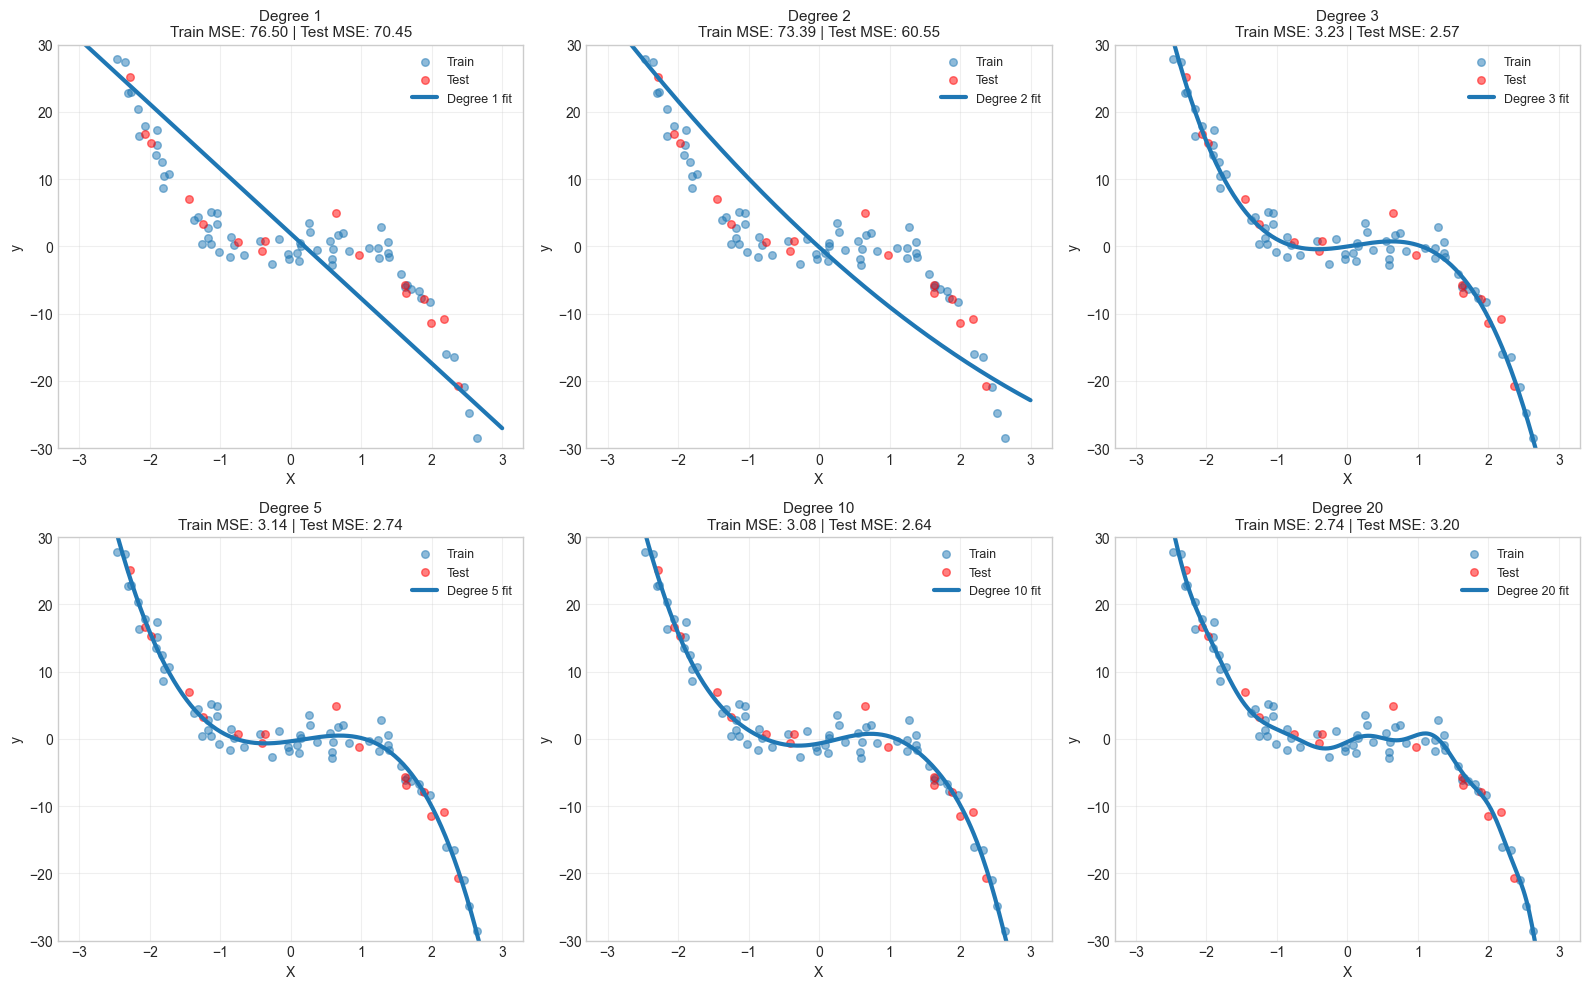

In [35]:
# Visualize the fits
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.ravel()

# Create smooth curve for plotting
X_plot = np.linspace(-3, 3, 300).reshape(-1, 1)

for idx, degree in enumerate(degrees):
    ax = axes[idx]
    
    # Get model and poly features
    model = results[degree]['model']
    poly_features = results[degree]['poly_features']
    
    # Make predictions on smooth curve
    X_plot_poly = poly_features.transform(X_plot)
    y_plot = model.predict(X_plot_poly)
    
    # Plot
    ax.scatter(X_train, y_train, alpha=0.5, s=30, label='Train')
    ax.scatter(X_test, y_test, alpha=0.5, s=30, color='red', label='Test')
    ax.plot(X_plot, y_plot, linewidth=3, label=f'Degree {degree} fit')
    
    # Add metrics to title
    train_mse = results[degree]['train_mse']
    test_mse = results[degree]['test_mse']
    
    ax.set_xlabel('X')
    ax.set_ylabel('y')
    ax.set_title(f'Degree {degree}\nTrain MSE: {train_mse:.2f} | Test MSE: {test_mse:.2f}', 
                 fontsize=11)
    ax.legend(loc='upper right', fontsize=9)
    ax.grid(True, alpha=0.3)
    ax.set_ylim([-30, 30])

plt.tight_layout()
plt.show()

## 3. Understanding Underfitting vs Overfitting

### 🔍 What did we observe?

**Degree 1 (Linear):**
- **Underfitting (High Bias)** 📉
- Too simple to capture the pattern
- Poor performance on both training and test data

**Degree 2-3:**
- **Just Right!** ✅
- Captures the underlying pattern
- Good performance on both sets

**Degree 10-20:**
- **Overfitting (High Variance)** 📈
- Fits training data too closely (including noise)
- Great training performance, poor test performance
- Wild oscillations between data points

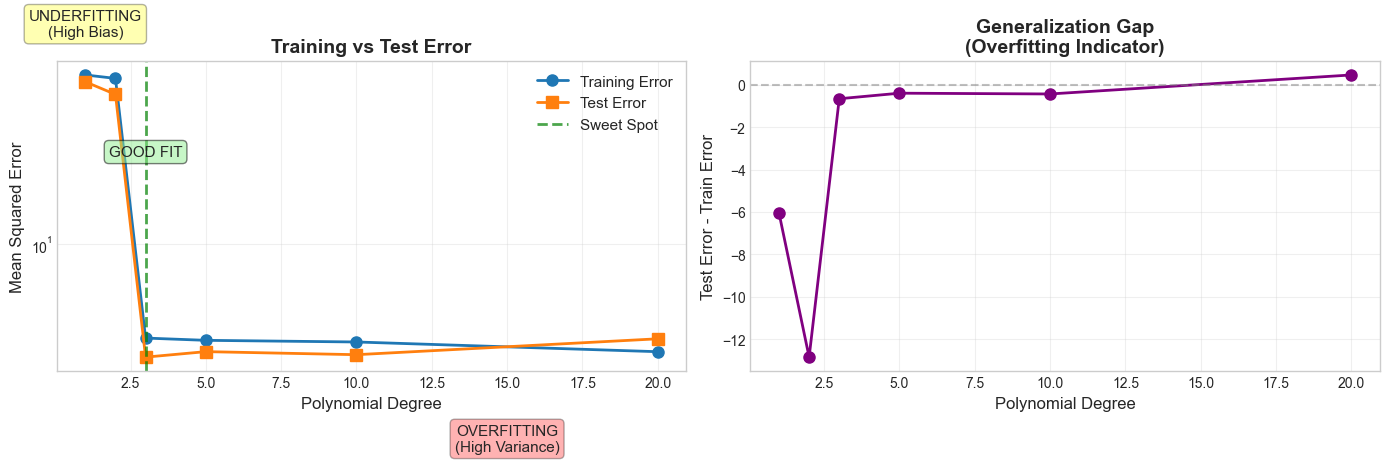


💡 Key Insight:
When the gap between training and test error is large, we're overfitting!


In [29]:
# Plot training vs test error
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# MSE comparison
train_errors = [results[d]['train_mse'] for d in degrees]
test_errors = [results[d]['test_mse'] for d in degrees]

axes[0].plot(degrees, train_errors, 'o-', linewidth=2, markersize=8, label='Training Error')
axes[0].plot(degrees, test_errors, 's-', linewidth=2, markersize=8, label='Test Error')
axes[0].axvline(x=3, color='green', linestyle='--', alpha=0.7, linewidth=2, label='Sweet Spot')
axes[0].set_xlabel('Polynomial Degree', fontsize=12)
axes[0].set_ylabel('Mean Squared Error', fontsize=12)
axes[0].set_title('Training vs Test Error', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)
axes[0].set_yscale('log')

# Annotate regions
axes[0].text(1, test_errors[0]*2, 'UNDERFITTING\n(High Bias)', 
             ha='center', va='center', fontsize=11, 
             bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.3))
axes[0].text(3, test_errors[1]*0.5, 'GOOD FIT', 
             ha='center', va='center', fontsize=11,
             bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.5))
axes[0].text(15, test_errors[-1]*0.3, 'OVERFITTING\n(High Variance)', 
             ha='center', va='center', fontsize=11,
             bbox=dict(boxstyle='round', facecolor='red', alpha=0.3))

# Gap between train and test error
gaps = [test - train for train, test in zip(train_errors, test_errors)]
axes[1].plot(degrees, gaps, 'o-', linewidth=2, markersize=8, color='purple')
axes[1].axhline(y=0, color='gray', linestyle='--', alpha=0.5)
axes[1].set_xlabel('Polynomial Degree', fontsize=12)
axes[1].set_ylabel('Test Error - Train Error', fontsize=12)
axes[1].set_title('Generalization Gap\n(Overfitting Indicator)', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n💡 Key Insight:")
print("When the gap between training and test error is large, we're overfitting!")

## 4. Learning Curves

**Learning curves** show how training and validation errors change as we add more training data.

They help us diagnose:
- Is our model too simple (underfitting)?
- Is our model too complex (overfitting)?
- Would more data help?

### How to Read Learning Curves:

**Underfitting (High Bias):**
- Both curves plateau at a high error
- Small gap between them
- More data won't help much
- Solution: Use a more complex model

**Overfitting (High Variance):**
- Large gap between training and validation curves
- Training error is low, validation error is high
- More data should help close the gap
- Solution: Get more data or regularize

**Good Fit:**
- Both curves converge to a low error
- Small gap between them

Computing learning curves...


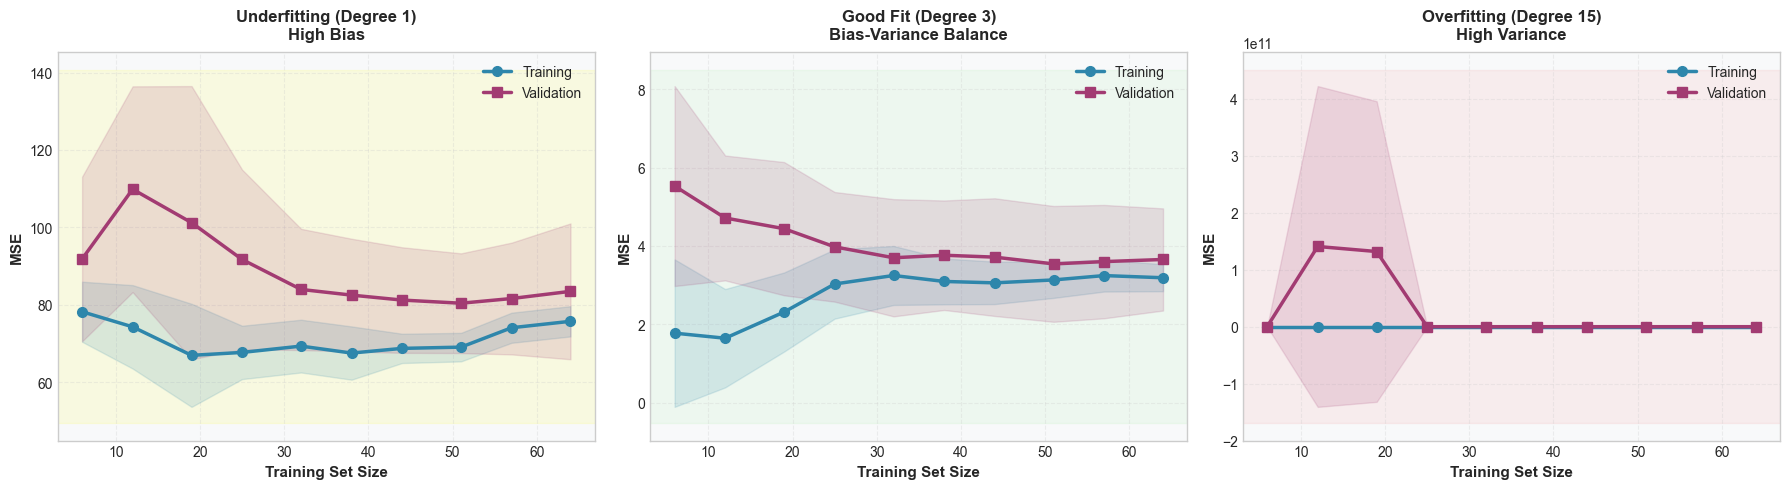

✅ Learning curves complete!

📊 Key observations:
  • Degree 1: Both errors remain high → Underfitting
  • Degree 3: Low errors with small gap → Good fit
  • Degree 15: Large gap between curves → Overfitting


In [30]:
# Create figure for learning curves comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Define models with different complexities
models_config = [
    (1, 'Underfitting (Degree 1)\nHigh Bias', 0, 'yellow'),
    (3, 'Good Fit (Degree 3)\nBias-Variance Balance', 1, 'lightgreen'),
    (15, 'Overfitting (Degree 15)\nHigh Variance', 2, 'lightcoral')
]

print("Computing learning curves...")

for degree, title, idx, color in models_config:
    # Create model pipeline
    model = Pipeline([
        ('poly', PolynomialFeatures(degree=degree)),
        ('linear', LinearRegression())
    ])
    
    # Calculate learning curves
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        train_sizes, train_scores, val_scores = learning_curve(
            model, X_train, y_train.ravel(),
            cv=5,
            train_sizes=np.linspace(0.1, 1.0, 10),
            scoring='neg_mean_squared_error',
            n_jobs=-1,
            verbose=0
        )
    
    # Convert to positive MSE and calculate statistics
    train_errors_mean = np.mean(-train_scores, axis=1)
    train_errors_std = np.std(-train_scores, axis=1)
    val_errors_mean = np.mean(-val_scores, axis=1)
    val_errors_std = np.std(-val_scores, axis=1)
    
    # Plot on corresponding axis
    ax = axes[idx]
    ax.plot(train_sizes, train_errors_mean, 'o-', linewidth=2.5, 
            markersize=7, label='Training', color='#2E86AB')
    ax.fill_between(train_sizes, 
                    train_errors_mean - train_errors_std,
                    train_errors_mean + train_errors_std,
                    alpha=0.15, color='#2E86AB')
    
    ax.plot(train_sizes, val_errors_mean, 's-', linewidth=2.5, 
            markersize=7, label='Validation', color='#A23B72')
    ax.fill_between(train_sizes,
                    val_errors_mean - val_errors_std,
                    val_errors_mean + val_errors_std,
                    alpha=0.15, color='#A23B72')
    
    # Styling
    ax.set_xlabel('Training Set Size', fontsize=11, fontweight='bold')
    ax.set_ylabel('MSE', fontsize=11, fontweight='bold')
    ax.set_title(title, fontsize=12, fontweight='bold', pad=10)
    ax.legend(loc='best', fontsize=10, framealpha=0.9)
    ax.grid(True, alpha=0.3, linestyle='--')
    ax.set_facecolor('#f8f9fa')
    
    # Add subtle background color
    ax.axhspan(ax.get_ylim()[0], ax.get_ylim()[1], alpha=0.1, color=color, zorder=0)

plt.tight_layout()
plt.show()

print("✅ Learning curves complete!")
print("\n📊 Key observations:")
print("  • Degree 1: Both errors remain high → Underfitting")
print("  • Degree 3: Low errors with small gap → Good fit")
print("  • Degree 15: Large gap between curves → Overfitting")

## 5. The Bias-Variance Trade-off

This is one of the most important concepts in machine learning!

### Total Error Decomposition:

$$\text{Total Error} = \text{Bias}^2 + \text{Variance} + \text{Irreducible Error}$$

### Understanding Each Component:

**1. Bias** 🎯
- Error from wrong assumptions in the learning algorithm
- **High bias** → Model is too simple → **Underfitting**
- Example: Using a linear model for non-linear data

**2. Variance** 📊
- Error from sensitivity to small fluctuations in training data
- **High variance** → Model is too complex → **Overfitting**
- Example: Using a degree-20 polynomial for simple data

**3. Irreducible Error** 🎲
- Noise in the data itself
- Cannot be reduced by any model

### The Trade-off:
- Increasing model complexity: ⬇️ Bias, ⬆️ Variance
- Decreasing model complexity: ⬆️ Bias, ⬇️ Variance
- Goal: Find the **sweet spot** that minimizes total error!

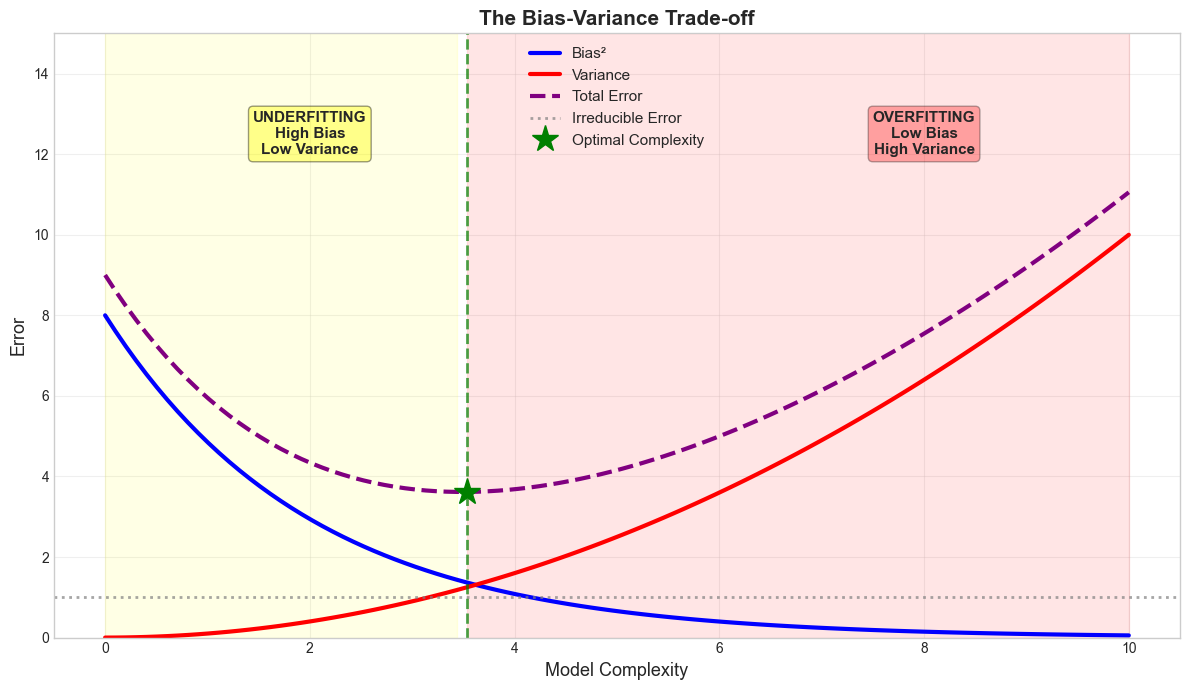


🎯 Key Takeaways:
1. As model complexity increases, bias decreases but variance increases
2. There's an optimal complexity that minimizes total error
3. Too simple → High bias (underfitting)
4. Too complex → High variance (overfitting)


In [31]:
# Visualize Bias-Variance Trade-off
complexity = np.linspace(0, 10, 100)

# Simulate bias (decreases with complexity)
bias = 8 * np.exp(-0.5 * complexity)

# Simulate variance (increases with complexity)
variance = 0.1 * complexity**2

# Total error
total_error = bias + variance + 1  # +1 for irreducible error

# Find optimal complexity
optimal_idx = np.argmin(total_error)
optimal_complexity = complexity[optimal_idx]

# Plot
plt.figure(figsize=(12, 7))
plt.plot(complexity, bias, linewidth=3, label='Bias²', color='blue')
plt.plot(complexity, variance, linewidth=3, label='Variance', color='red')
plt.plot(complexity, total_error, linewidth=3, label='Total Error', 
         color='purple', linestyle='--')
plt.axhline(y=1, color='gray', linestyle=':', linewidth=2, 
            label='Irreducible Error', alpha=0.7)

# Mark optimal point
plt.axvline(x=optimal_complexity, color='green', linestyle='--', 
            linewidth=2, alpha=0.7)
plt.plot(optimal_complexity, total_error[optimal_idx], 'g*', 
         markersize=20, label='Optimal Complexity')

# Add regions
plt.fill_between(complexity[:optimal_idx], 0, 15, alpha=0.1, color='yellow')
plt.fill_between(complexity[optimal_idx:], 0, 15, alpha=0.1, color='red')

plt.text(2, 12, 'UNDERFITTING\nHigh Bias\nLow Variance', 
         ha='center', fontsize=11, fontweight='bold',
         bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.4))
plt.text(8, 12, 'OVERFITTING\nLow Bias\nHigh Variance', 
         ha='center', fontsize=11, fontweight='bold',
         bbox=dict(boxstyle='round', facecolor='red', alpha=0.3))

plt.xlabel('Model Complexity', fontsize=13)
plt.ylabel('Error', fontsize=13)
plt.title('The Bias-Variance Trade-off', fontsize=15, fontweight='bold')
plt.legend(loc='upper center', fontsize=11)
plt.grid(True, alpha=0.3)
plt.ylim([0, 15])
plt.tight_layout()
plt.show()

print("\n🎯 Key Takeaways:")
print("1. As model complexity increases, bias decreases but variance increases")
print("2. There's an optimal complexity that minimizes total error")
print("3. Too simple → High bias (underfitting)")
print("4. Too complex → High variance (overfitting)")

## 6. Regularization: Controlling Complexity

Instead of reducing polynomial degree, we can use **regularization** to control overfitting.

Ridge regression adds a penalty for large coefficients, effectively reducing model complexity.

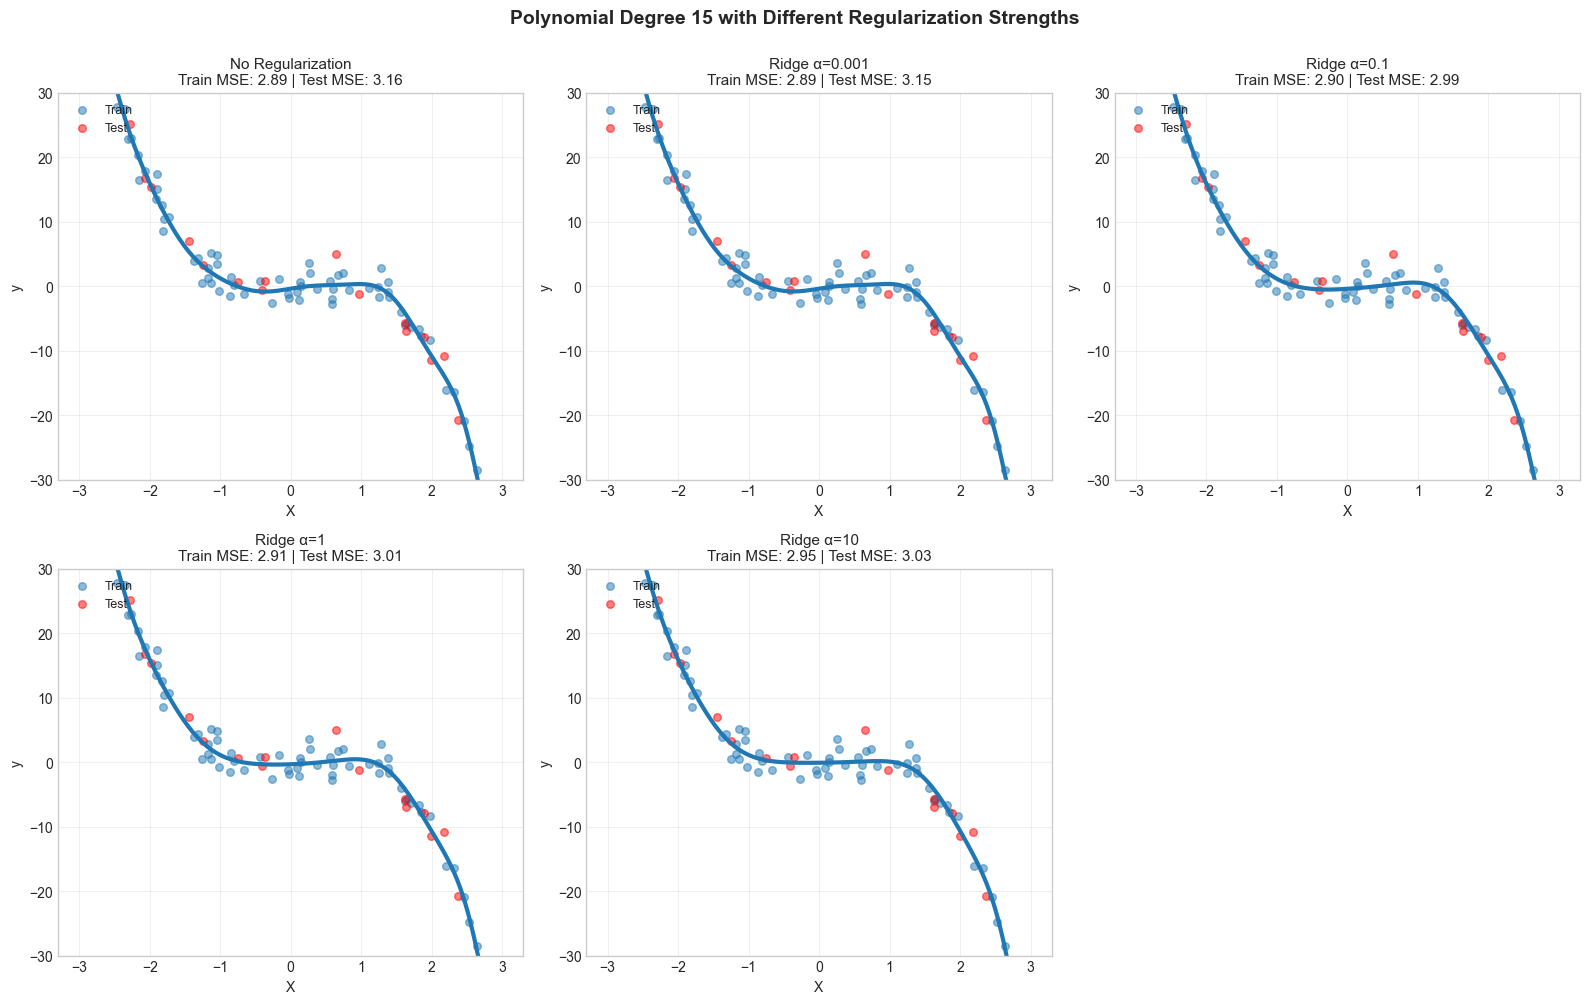


💡 Observation:
Regularization helps control overfitting without reducing polynomial degree!
The curve becomes smoother as α increases.


In [32]:
# Compare high-degree polynomial with and without regularization
degree = 15
alphas = [0, 0.001, 0.1, 1, 10]

fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.ravel()

# Prepare polynomial features
poly_features = PolynomialFeatures(degree=degree, include_bias=False)
X_train_poly = poly_features.fit_transform(X_train)
X_test_poly = poly_features.transform(X_test)
X_plot_poly = poly_features.transform(X_plot)

for idx, alpha in enumerate(alphas):
    ax = axes[idx]
    
    # Fit model
    if alpha == 0:
        model = LinearRegression()
        title_prefix = "No Regularization"
    else:
        model = Ridge(alpha=alpha)
        title_prefix = f"Ridge α={alpha}"
    
    model.fit(X_train_poly, y_train)
    
    # Predictions
    y_train_pred = model.predict(X_train_poly)
    y_test_pred = model.predict(X_test_poly)
    y_plot = model.predict(X_plot_poly)
    
    # Errors
    train_mse = mean_squared_error(y_train, y_train_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)
    
    # Plot
    ax.scatter(X_train, y_train, alpha=0.5, s=30, label='Train')
    ax.scatter(X_test, y_test, alpha=0.5, s=30, color='red', label='Test')
    ax.plot(X_plot, y_plot, linewidth=3)
    ax.set_xlabel('X')
    ax.set_ylabel('y')
    ax.set_title(f'{title_prefix}\nTrain MSE: {train_mse:.2f} | Test MSE: {test_mse:.2f}',
                 fontsize=11)
    ax.legend(loc='upper left', fontsize=9)
    ax.grid(True, alpha=0.3)
    ax.set_ylim([-30, 30])

# Remove extra subplot
fig.delaxes(axes[-1])

plt.suptitle(f'Polynomial Degree {degree} with Different Regularization Strengths', 
             fontsize=14, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

print("\n💡 Observation:")
print("Regularization helps control overfitting without reducing polynomial degree!")
print("The curve becomes smoother as α increases.")

## 7. Practical Guidelines

### Diagnosing Your Model:

| Symptom | Problem | Solution |
|---------|---------|----------|
| High training error | Underfitting (High Bias) | • Use more complex model<br>• Add more features<br>• Reduce regularization |
| Large train-test gap | Overfitting (High Variance) | • Get more training data<br>• Reduce model complexity<br>• Add regularization<br>• Remove features |
| Both errors high | Underfitting + Bad features | • Use better features<br>• Increase model complexity |
| Low training error, low test error | Good fit! ✅ | Keep doing what you're doing! |

### Using Learning Curves:

1. **Both curves converge to high error**:
   - Problem: Underfitting
   - Solution: More complex model
   - More data won't help much

2. **Large gap between curves**:
   - Problem: Overfitting
   - Solution: More data or regularization
   - Gap should close with more data

3. **Both curves converge to low error**:
   - You're doing great! 🎉

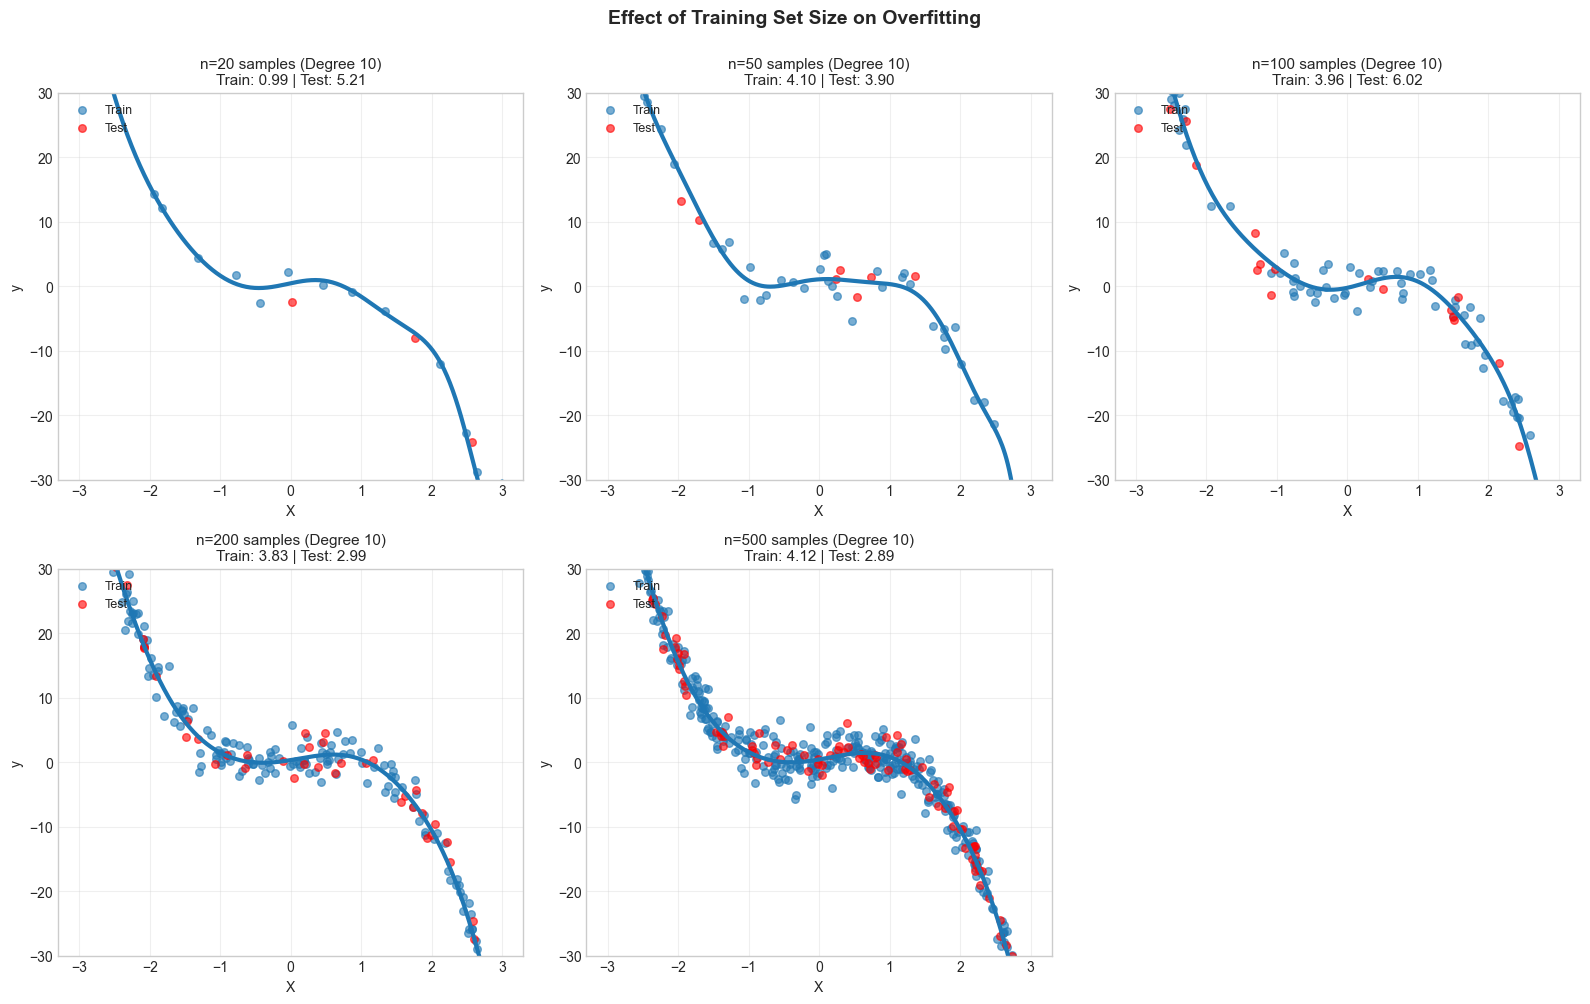


📊 Notice how the wild oscillations decrease as we add more data!
More data helps the model learn the true underlying pattern instead of memorizing noise.


In [33]:
# Demonstrate the effect of training set size
def demonstrate_data_effect():
    """
    Show how more data helps with overfitting
    """
    sample_sizes = [20, 50, 100, 200, 500]
    degree = 10  # Complex model
    
    fig, axes = plt.subplots(2, 3, figsize=(16, 10))
    axes = axes.ravel()
    
    for idx, m in enumerate(sample_sizes):
        if idx >= len(axes):
            break
            
        ax = axes[idx]
        
        # Generate data
        X_temp, y_temp = generate_data(m=m, noise=2)
        X_temp_train, X_temp_test, y_temp_train, y_temp_test = train_test_split(
            X_temp, y_temp, test_size=0.2, random_state=42
        )
        
        # Fit model
        poly = PolynomialFeatures(degree=degree)
        X_temp_train_poly = poly.fit_transform(X_temp_train)
        X_temp_test_poly = poly.transform(X_temp_test)
        X_plot_poly = poly.transform(X_plot)
        
        model = LinearRegression()
        model.fit(X_temp_train_poly, y_temp_train)
        
        # Predict
        y_train_pred = model.predict(X_temp_train_poly)
        y_test_pred = model.predict(X_temp_test_poly)
        y_plot = model.predict(X_plot_poly)
        
        train_mse = mean_squared_error(y_temp_train, y_train_pred)
        test_mse = mean_squared_error(y_temp_test, y_test_pred)
        
        # Plot
        ax.scatter(X_temp_train, y_temp_train, alpha=0.6, s=30, label='Train')
        ax.scatter(X_temp_test, y_temp_test, alpha=0.6, s=30, color='red', label='Test')
        ax.plot(X_plot, y_plot, linewidth=3)
        ax.set_xlabel('X')
        ax.set_ylabel('y')
        ax.set_title(f'n={m} samples (Degree {degree})\nTrain: {train_mse:.2f} | Test: {test_mse:.2f}',
                     fontsize=11)
        ax.legend(loc='upper left', fontsize=9)
        ax.grid(True, alpha=0.3)
        ax.set_ylim([-30, 30])
    
    fig.delaxes(axes[-1])
    plt.suptitle('Effect of Training Set Size on Overfitting', 
                 fontsize=14, fontweight='bold', y=1.00)
    plt.tight_layout()
    plt.show()

demonstrate_data_effect()

print("\n📊 Notice how the wild oscillations decrease as we add more data!")
print("More data helps the model learn the true underlying pattern instead of memorizing noise.")

## 8. Summary: The Complete Picture

###  Main Concepts:

1. **Polynomial Regression**:
   - Extends linear regression to non-linear relationships
   - Still linear in parameters
   - Degree controls model complexity

2. **Underfitting (High Bias)**:
   - Model too simple
   - High error on both train and test
   - Solution: Increase complexity

3. **Overfitting (High Variance)**:
   - Model too complex
   - Low training error, high test error
   - Solution: More data, regularization, or reduce complexity

4. **Learning Curves**:
   - Diagnostic tool for model performance
   - Shows effect of training set size
   - Helps identify bias vs variance problems

5. **Bias-Variance Trade-off**:
   - Fundamental concept in ML
   - Total Error = Bias² + Variance + Irreducible Error
   - Goal: Find optimal complexity

6. **Regularization**:
   - Controls complexity without changing degree
   - Helps prevent overfitting
   - α parameter controls strength

###  Practical Workflow:

```
1. Start simple (low degree)
2. Plot learning curves
3. Diagnose:
   - High bias? → Increase complexity
   - High variance? → More data or regularization
4. Iterate until satisfied
5. Evaluate on test set
```

###  Remember:

- **More data** helps with high variance (overfitting)
- **More features/complexity** helps with high bias (underfitting)
- **Regularization** helps with high variance
- **Learning curves** are your friend for diagnosis!
- There's always a **trade-off** between bias and variance

---

## Conclusion

### Core Machine Learning Principles

This notebook covered fundamental concepts that apply to **all machine learning models**:

**1. Model Complexity Management**
- Understanding when a model is too simple or too complex
- Balancing model capacity with available data
- Finding the optimal point between underfitting and overfitting

**2. Diagnostic Tools**
- Using learning curves to identify performance issues
- Analyzing training vs validation metrics
- Making data-driven decisions about model improvements

**3. The Universal Trade-off**
- Every model faces the bias-variance trade-off
- Complexity adjustments have predictable effects on performance
- There's no one-size-fits-all solution

**4. Practical Problem-Solving**
- Diagnose first, then act
- Consider multiple solutions (more data, regularization, simpler/complex models)
- Validate changes systematically

### Key Takeaway

Whether you're working with linear models, decision trees, neural networks, or any other algorithm, these principles remain constant. Mastering them will make you a better machine learning practitioner across any domain or technique.